In [16]:
import mne
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view as sliding
import pandas as pd
import os
from scipy import signal
from matplotlib import pyplot as plt

# What is this file

This is my first try to process our Unicorn recordings into a format suitable for the TinySleepNet model. It takes one CSV file and saves a NPZ file which should be ready to give to the `predict.py` of TinySleepNet.

### NOT YET TESTED!

# Main info

TiniSleepNet uses the Fpz-Cz channel for predictions. That means, the informative channel is Fpz and the reference is Cz.

Unicorn does not provide Fpz channel. Fpz-Cz is unavailable for us.

The other channel in the training data is Pz-Oz. We can use it instead.

So, we need to re-train the TiniSleepNet on this channel.

## Read the CSV data

In [135]:
path = 'data/test.csv'
df = pd.read_csv(path)

unicorn_ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
df = df.rename(columns=dict(zip([f'EEG {i}' for i in range(1, 9)], unicorn_ch_names)))

print(df.shape)
df.head()

(1616168, 17)


,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,Accelerometer X,Accelerometer Y,Accelerometer Z,Gyroscope X,Gyroscope Y,Gyroscope Z,Battery Level,Counter,Validation Indicator
0,-2.578,2.762,40.579,12.129,-12.545,-2.202,3.852,-7.365,0.889,0.446,-0.220,1.099,1.007,1.556,100.0,63705.0,1.0
1,-1.209,3.399,-7.059,16.379,-11.112,-0.630,5.994,-7.360,0.891,0.445,-0.221,1.160,0.977,1.495,100.0,63706.0,1.0
2,-0.747,3.379,-58.926,18.547,-7.593,-0.454,6.627,-8.228,0.891,0.445,-0.221,1.160,0.946,1.465,100.0,63707.0,1.0
3,-1.030,3.298,-92.135,17.661,-2.965,-1.718,5.487,-9.482,0.891,0.446,-0.221,1.129,1.007,1.404,100.0,63708.0,1.0
4,-1.631,3.095,-90.644,14.166,0.671,-3.821,3.117,-10.496,0.890,0.447,-0.220,1.160,1.038,1.434,100.0,63709.0,1.0


### Rereferencing to get Pz-Oz

In [136]:
Pz_Oz = df['Pz'] - df['Oz']

# Noise detection and removal

Normal EEG is usually under 100 uV. Discard everything higher than 150 uV.

Check accelerometer to discard any remaining noisy segments.

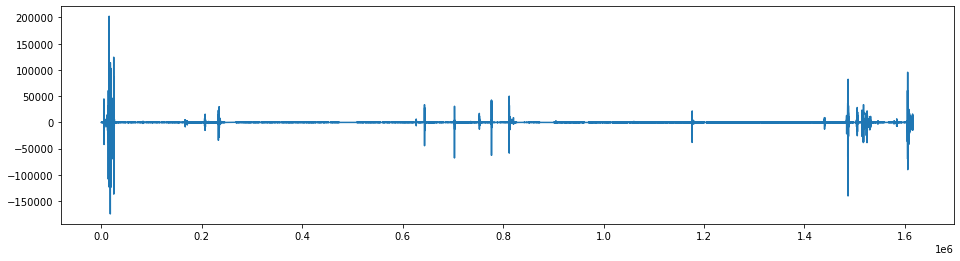

In [138]:
plt.figure(figsize=(16, 4))
plt.plot(Pz_Oz)

By looking at the plot, the noise seems to be of much higher magnitude than the "common" signal.

TinySleepNet uses 3000 point segments, which is 30 s with 100 Hz sample rate. Ours is 250 Hz. That is 3000 * 2.5 = 7500 points per segment. Segment less than that should be discarded.

In [139]:
cut_segments = np.split(Pz_Oz, Pz_Oz[np.abs(Pz_Oz) > 150].index.to_numpy())
good_data = [x[1:] for x in cut_segments if len(x)>=7501]

lens = [len(x) for x in good_data]
print(f'There are {len(good_data)} segments with length from {min(lens)} to {max(lens)} points')
print(f'Highest amplitude: {max([max(x) for x in good_data])} uV')

There are 32 segments with length from 8204 to 284380 points
Highest amplitude: 149.499 uV


Print all segments

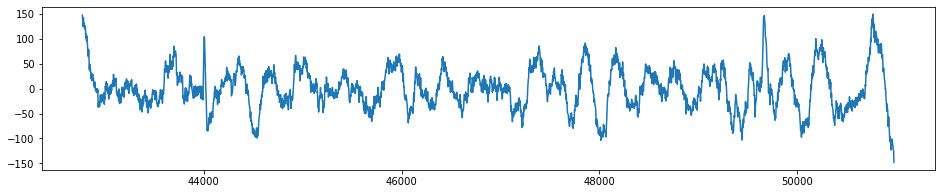

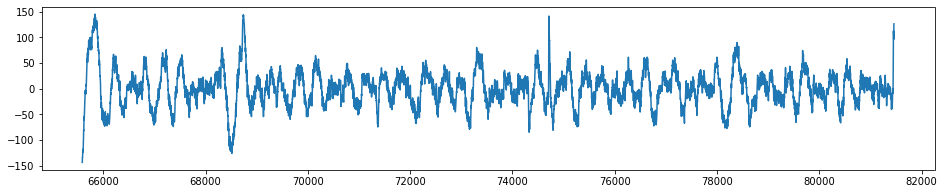

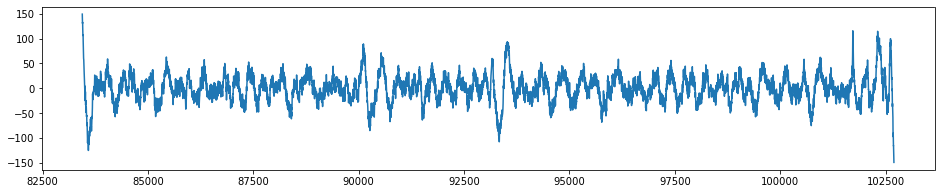

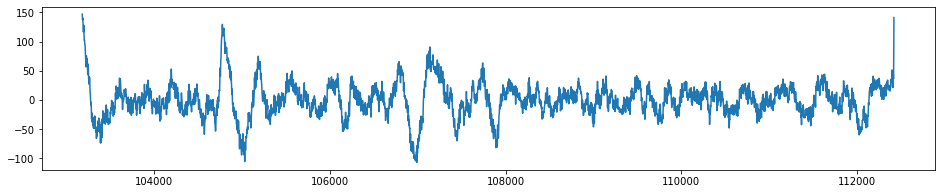

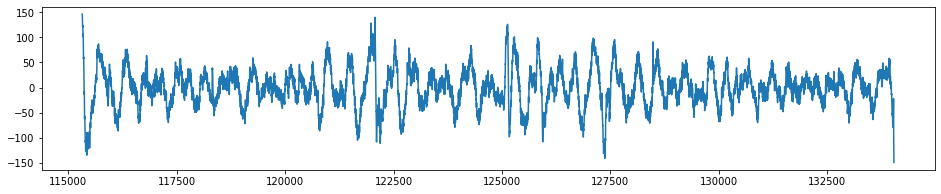

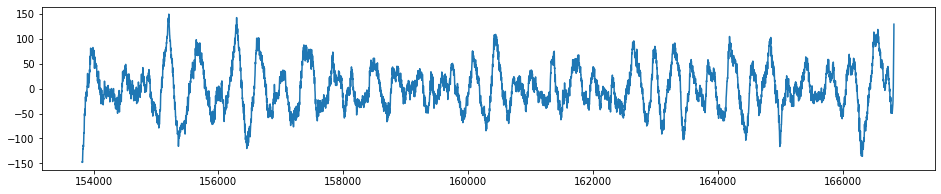

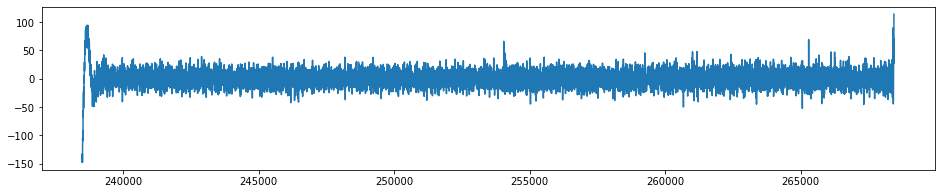

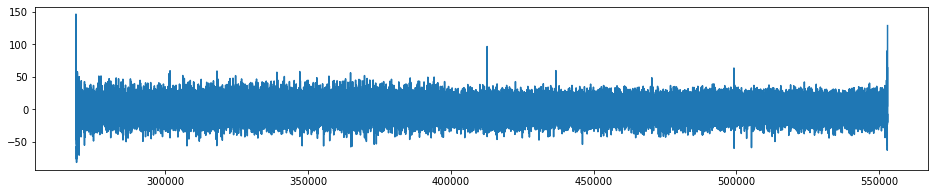

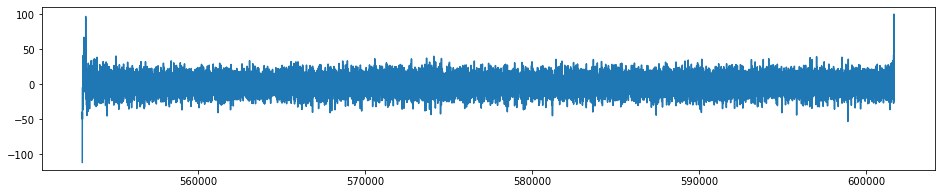

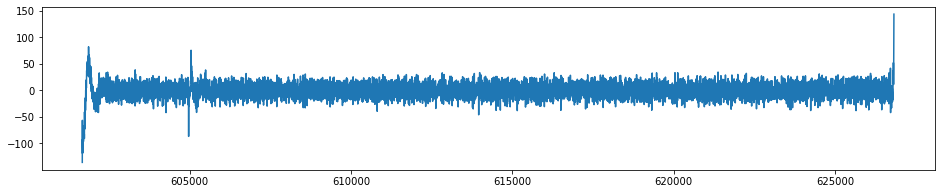

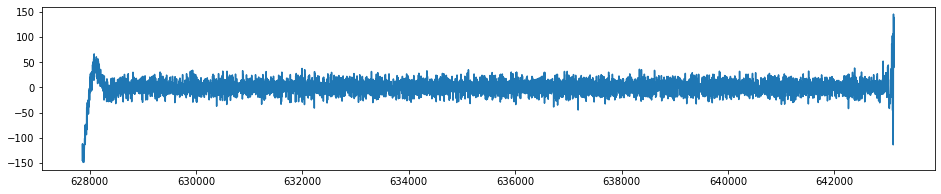

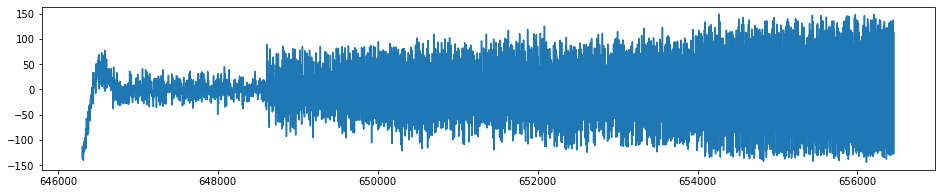

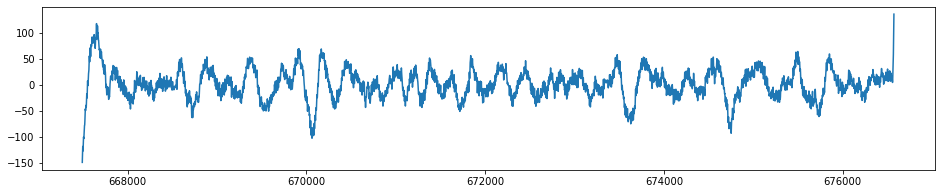

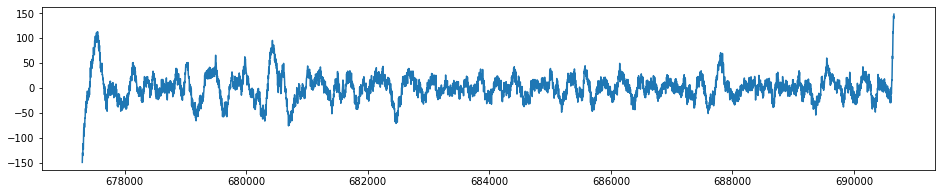

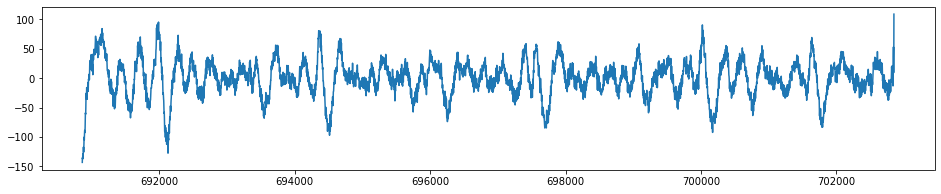

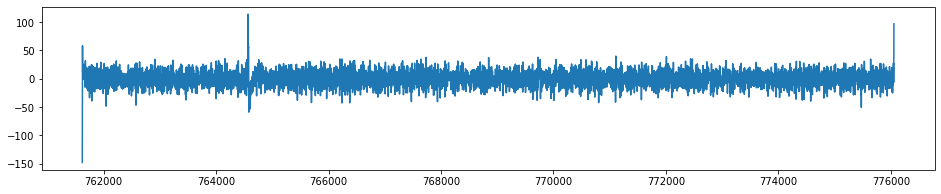

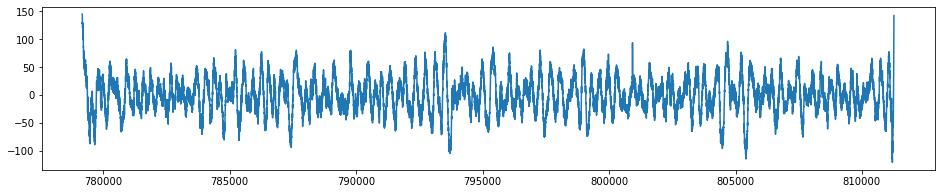

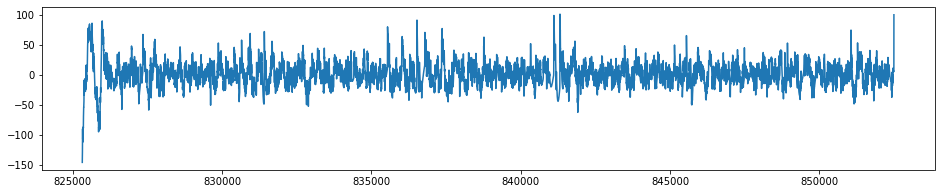

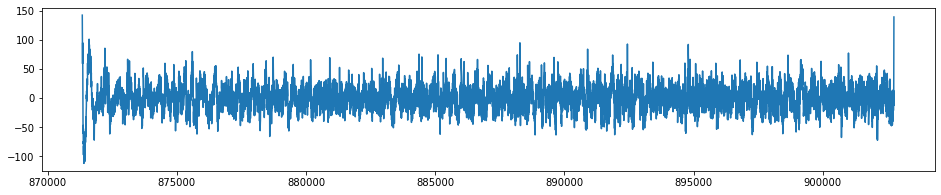

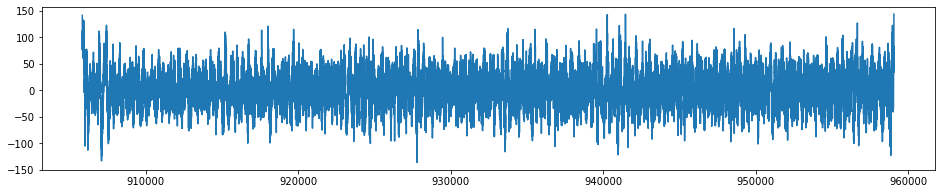

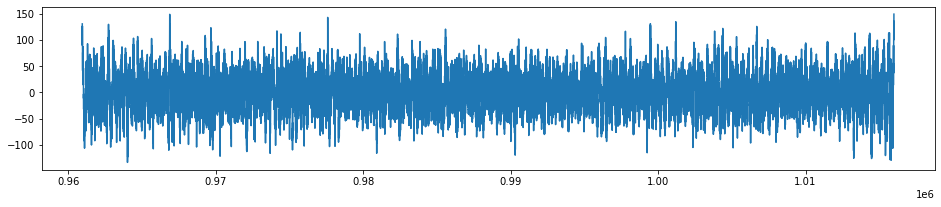

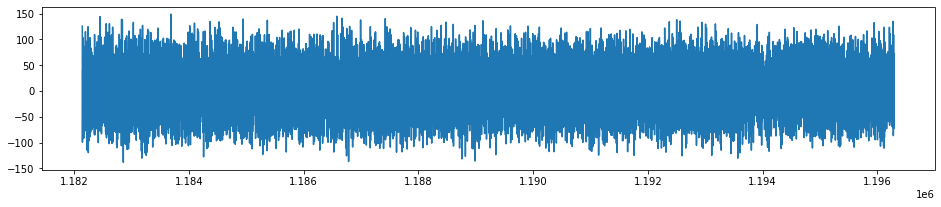

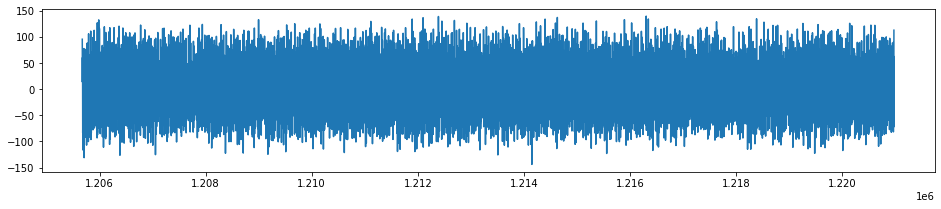

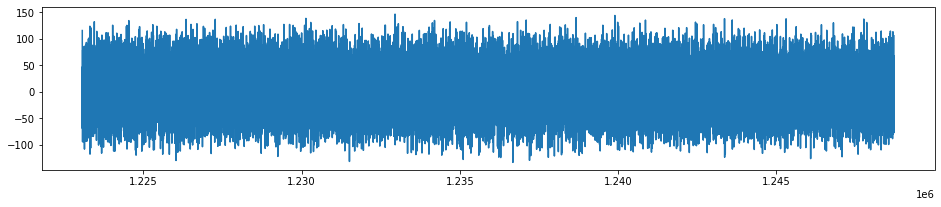

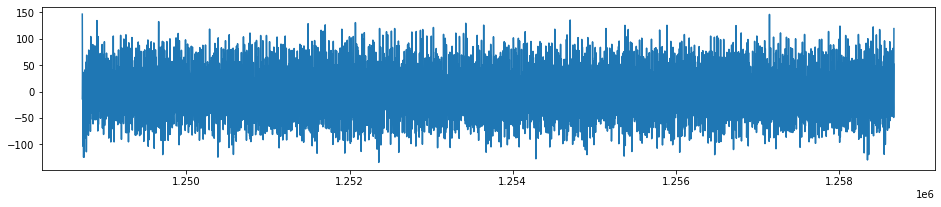

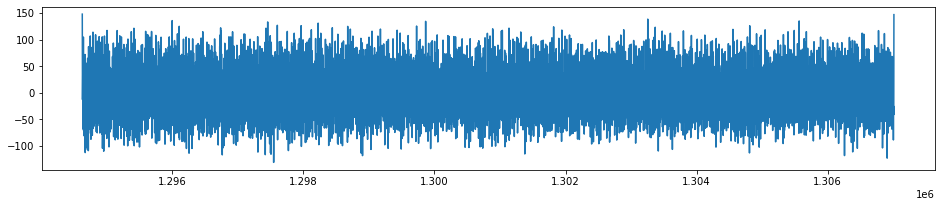

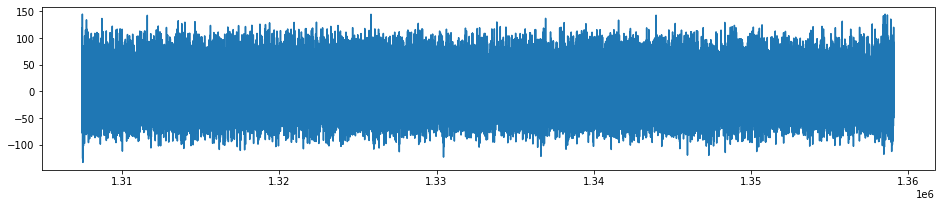

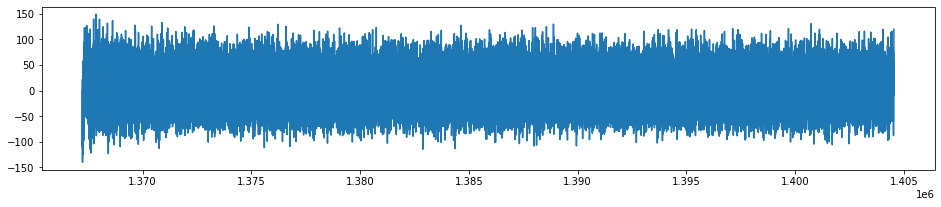

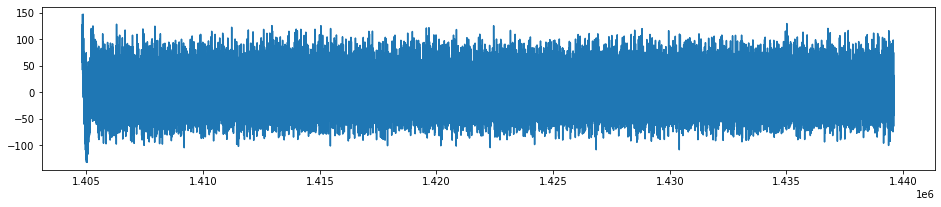

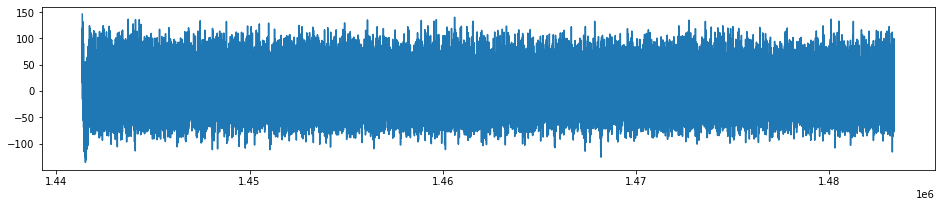

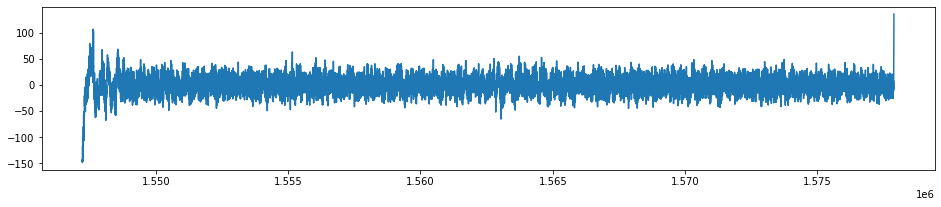

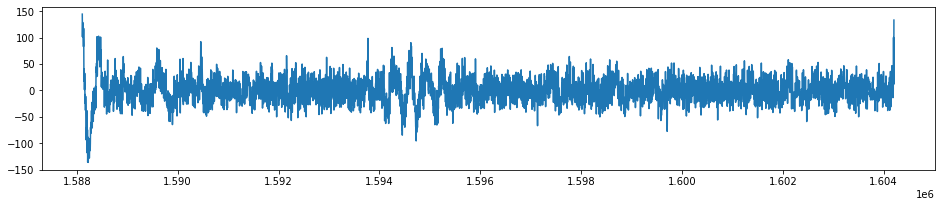

In [140]:
for segment in good_data:
    plt.figure(figsize=(16, 3))
    plt.plot(segment)
    plt.show()

## Check accelerometer

In [142]:
df[['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']].describe()

,Accelerometer X,Accelerometer Y,Accelerometer Z
count,1.616168e+06,1.616168e+06,1.616168e+06
mean,7.785090e-01,5.747616e-01,-6.479984e-02
std,2.050695e-01,1.182992e-01,1.806615e-01
min,-9.910000e-01,8.800000e-02,-9.280000e-01
25%,7.600000e-01,4.860000e-01,-2.290000e-01
50%,8.560000e-01,5.040000e-01,-1.820000e-01
75%,8.710000e-01,6.570000e-01,8.500000e-02
max,1.200000e+00,1.931000e+00,7.960000e-01


In [158]:
window_size = 200
rolling = sliding(df['Pz'], window_size).mean(-1)
print(np.corrcoef(df['Accelerometer X'][window_size//2:-window_size//2 + 1], rolling)[0][1])
print(np.corrcoef(df['Accelerometer Y'][window_size//2:-window_size//2 + 1], rolling)[0][1])
print(np.corrcoef(df['Accelerometer Z'][window_size//2:-window_size//2 + 1], rolling)[0][1])

0.0022564465204840817
0.001674883424343417
-0.001213855473353031


There are no simple correlation between accelerometer values and amplitude values. Other ways may be needed to remove additional noise in segments.

In [143]:
good_idx = Pz_Oz[np.abs(Pz_Oz) <= 150].index
df.loc[good_idx, ['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']].max()

Accelerometer X    1.034
Accelerometer Y    1.340
Accelerometer Z    0.702
dtype: float64

### (OLD) Getting only good segments using Validation Indicator

In [122]:
# good_data = []
# idx = df[df['Validation Indicator'].diff().isin([1, -1])].index.tolist()
# idx.insert(0, 0)
# idx.append(len(df))

# for i_start, i_end in zip(idx[::2], idx[1::2]):
#     good_data.append(Pz_Oz[i_start:i_end-1])
    
# lens = [len(x) for x in good_data]
# print(f'N segments: {len(good_data)} with length from {min(lens)} to {max(lens)} points')

N segments: 2722 with length from 7 to 604967 points


#### Sanity check
Plot some segments to see where they are

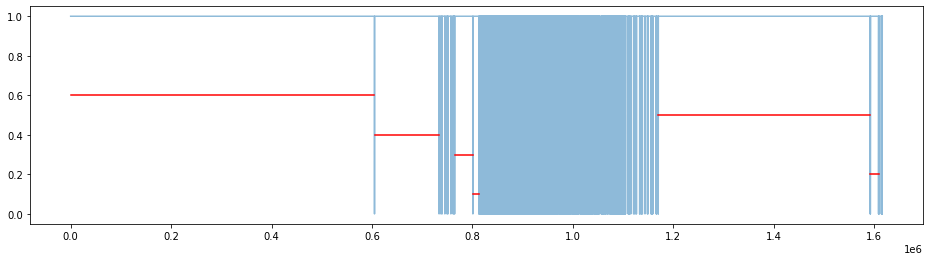

In [157]:
# biggest_segments = np.argsort([len(x) for x in good_data])[-6:] 
# plt.figure(figsize=(16, 4))
# plt.plot(df['validation'], alpha=.5)   # blue lines show the validation column values
# for i in range(6):
#     plt.plot((idx[biggest_segments[i]*2], idx[biggest_segments[i]*2+1]), (.1+(i/10), .1+(i/10)), color='red')

### Resampling

The sampling rate in the model was 100, but we have 250. We need to resample the data first.

In [119]:
segments = [signal.resample(x, round(len(x)/250*100)) for x in good_data]
lens = [len(x) for x in segments]
print(f'Resampled segments are with length from {min(lens)} to {max(lens)} points')

Resampled segments are with length from 3282 to 113752 points


### Cutting segments into correct shape for the model

**TODO:** scale the data accordingly from uV to ???

In the model, each segments contains 30 seconds, that is 3000 time points.

All smaller segments should be dropped, and bigger segments - cut into smaller.

In [120]:
X = []
for segment in segments:  # get overlapping segments with 3000 points each (overlap in half)
    for i in range(len(segment) // 1500):
        X.append(segment[i * 1500 : i * 1500 + 3000])
X = [x for x in X if len(x)==3000]
print(f'Got {len(X)} segments with length of 3000 points each')

Got 228 segments with length of 3000 points each


### Plot some examples

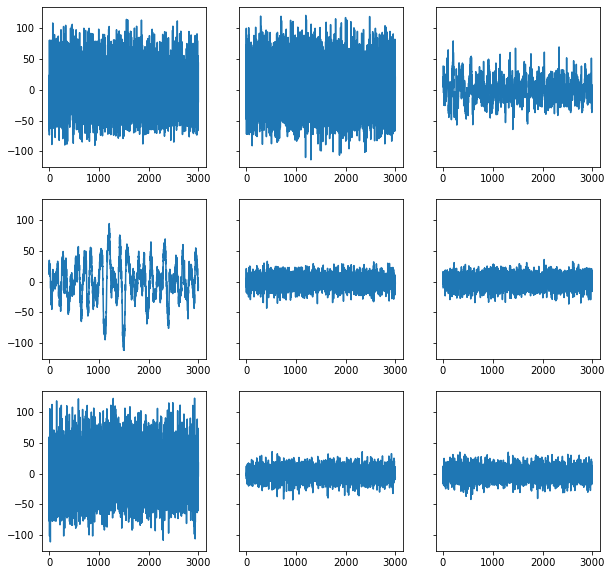

In [121]:
rand = np.random.choice(range(len(X)), size=9, replace=False)

fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
for i, ax in enumerate(axs.ravel()):
    ax.plot(X[rand[i]])

### Saving the segments in the correct format
* X: our segments as an array
* Y: some dummy values as we are predicting only
* fs: 100
* ch_label: 'EEG Pz-Oz'
* start_datetime: not important, so some random date
* file_duration: the duration of the total file
* epoch_duration: 30 s
* n_all_epochs: not sure, number of segments? (in the train file, some epochs are dropped of, and this is the number of total epochs)
* n_epochs: number of segments

In [95]:
save_dict = {
    "x": np.array(X), 
    "y": np.array([0] * len(X)), 
    "fs": 100,
    "ch_label": 'EEG Pz-Oz',
    "start_datetime": 'none',
    "file_duration": len(df) // 250,
    "epoch_duration": 30.0,
    "n_all_epochs": len(X),
    "n_epochs": len(X),
}
filename = 'data/unicorncsv/unicorn_0.npz'
np.savez(filename, **save_dict)

## OLD: Create MNE object
**Note:** it is unnecesarry, as the model uses numpy arrays

In [ ]:
# ch_types = ['eeg'] * 8 + ['stim']

# info = mne.create_info(ch_names=df.columns.tolist(), 
#                        sfreq=250, 
#                        ch_types=ch_types)
# info.set_montage('standard_1020')

# raw = mne.io.RawArray(df.transpose(), 
#                       info)

In [ ]:
# raw.plot(duration=1000, start=4000, scalings={'eeg': 5e-4});

In [ ]:
# events = mne.find_events(raw, stim_channel='validation', initial_event=True)